# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [2]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


In [3]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/asl_data/'
DATA_PATH = 'asl_data/'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [4]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Importar Images

In [5]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [7]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Create a function that will allow you to split the previously loaded validation set
    into valition and test.
    '''

    if shuffle:
        indexes = np.random.permutation(len(x))

        x = x[indexes]
        y = y[indexes]

    validation_size = int(len(x)*pct)

    x_val, x_test = x[:validation_size], x[validation_size:]
    y_val, y_test = y[:validation_size], y[validation_size:]

    return x_val, y_val, x_test, y_test

In [8]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [6]:
### The following

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise

In [10]:
x_mean, x_std, x_min =x_train.mean(), x_train.std(), x_train.min()

In [11]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [12]:
x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

### Graficar muestras

In [23]:
def plot_sign(image):

    image_reshaped = np.reshape(image, (28, 28))

    plt.figure(figsize=(5,5))
    plt.imshow(image_reshaped.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa la letra: 8


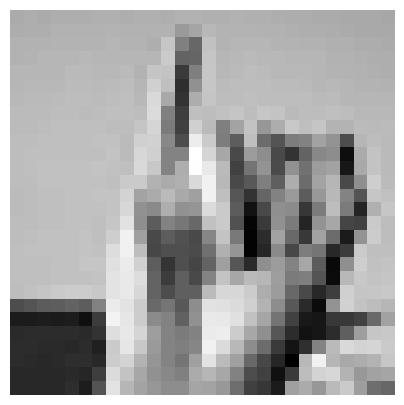

In [30]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa la letra: {y_test[rnd_idx]}')
plot_sign(x_test[rnd_idx])

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

## Nuestra clase Linear, ReLU y Sequential

###  Clase Linear

### Clase ReLU

### Clase Sequential

### Cost Function

### Loop de entrenamiento

### Create your model and train it

### Test your model on Random data from your test set

In [ ]:
idx = np.random.randint(len(y_test))
plot_number(x_test[idx].reshape(28,28))
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {alphabet[pred]} el valor real es:{alphabet[y_test[idx]]}')